In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as ping

In [2]:
raw = pd.read_csv('website_ab_test.csv')

In [3]:
raw

,Theme,Click Through Rate,Conversion Rate,Bounce Rate,Scroll_Depth,Age,Location,Session_Duration,Purchases,Added_to_Cart
0,Light Theme,0.054920,0.282367,0.405085,72.489458,25,Chennai,1535,No,Yes
1,Light Theme,0.113932,0.032973,0.732759,61.858568,19,Pune,303,No,Yes
2,Dark Theme,0.323352,0.178763,0.296543,45.737376,47,Chennai,563,Yes,Yes
3,Light Theme,0.485836,0.325225,0.245001,76.305298,58,Pune,385,Yes,No
4,Light Theme,0.034783,0.196766,0.765100,48.927407,25,New Delhi,1437,No,No
...,...,...,...,...,...,...,...,...,...,...
995,Dark Theme,0.282792,0.401605,0.200720,68.478822,25,Kolkata,321,Yes,Yes
996,Dark Theme,0.299917,0.026372,0.762641,73.019821,38,Chennai,1635,Yes,Yes
997,Light Theme,0.370254,0.019838,0.607136,33.963298,32,Bangalore,1237,No,Yes
998,Light Theme,0.095815,0.137953,0.458898,37.429284,24,Chennai,893,Yes,No


In [4]:
map_themes = {'Light Theme': 0, 'Dark Theme': 1}
map_binary = {'No': 0, 'Yes': 1}
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
raw['Theme'] = raw['Theme'].map(map_themes)
raw['Location'] = LE.fit_transform(raw['Location'])
raw['Purchases'] = raw['Purchases'].map(map_binary)
raw['Added_to_Cart'] = raw['Added_to_Cart'].map(map_binary)

## Hypothesis 1:
Light Theme users are more likely to add something to their carts than dark users

H_a: Mu1 <= Mu2

H_0: Mu1 > Mu2

In [5]:
# split into two groups
light = raw.query('Theme == 0')
dark = raw.query('Theme == 1')

In [6]:
# randomly sample 150 points from each group with no replacement; 300 total
light_sample = light.sample(150, replace=False)
dark_sample = dark.sample(150, replace=False)

In [7]:
from scipy.stats import ttest_ind

# t-test time
t,p = ttest_ind(light_sample['Added_to_Cart'], dark_sample['Added_to_Cart'], equal_var=False)

print("t-statistic: ", t)
print("p-value: ", p)

t-statistic:  0.4615292973925696
p-value:  0.6447556198511541


Given an alpha of 0.05; p > alpha (0.205) so we fail to reject the null hypothesis. Light theme users appear to be more likely to add something to their cart than dark users.

## One way Analysis of Variance

Definitions:

Click through rate (CTR): Measures how often people click on an ad, email, or webpage after seeing it.
Conversion rate (CR): Percentage which measures how many users complete a given action after interacting with a digital asset.
Bounce rate (BR): Measures the percentage of visitors to a website who leave after viewing only one page.

We postulate the following hypothesis for ANOVA:

***H0: Means of CTR for each group are the same***

***Ha: At least one of the means is different***


We first check the assumptions to see if an ANOVA will be useful:

In [8]:
import statsmodels.api as sm
import seaborn as sns

sample_data = pd.concat([light_sample, dark_sample], axis=0)

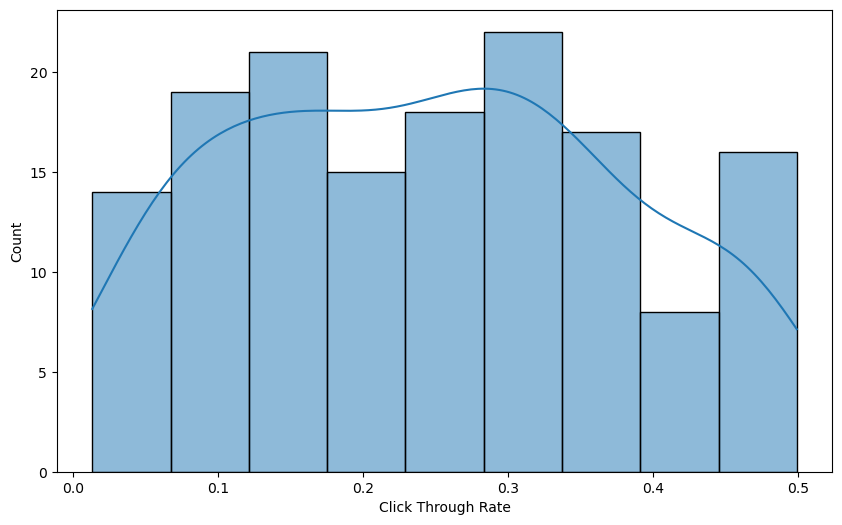

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(light_sample, x='Click Through Rate', kde=True)
plt.show()

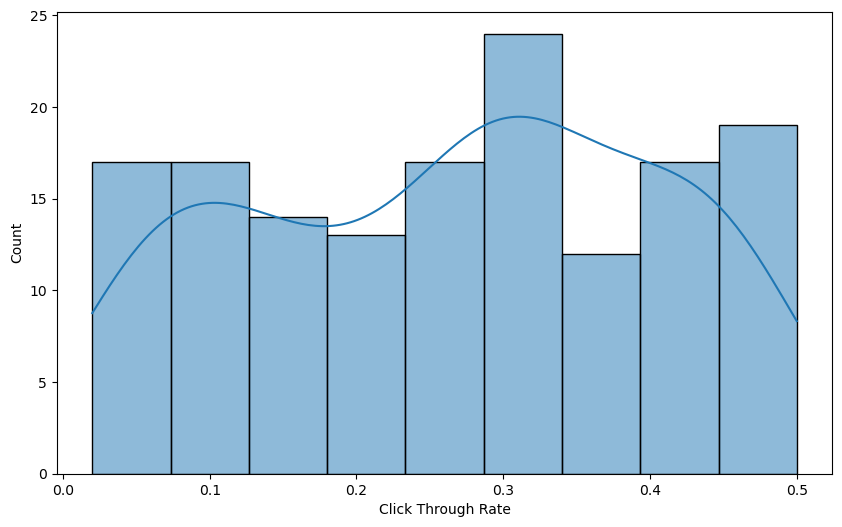

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(dark_sample, x='Click Through Rate', kde=True)
plt.show()

<Figure size 1000x600 with 0 Axes>

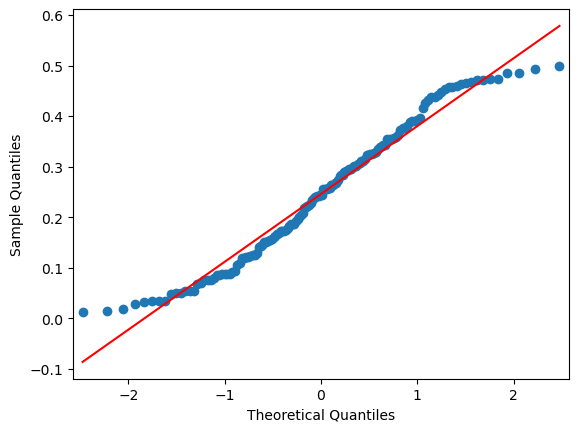

In [11]:
plt.figure(figsize=(10, 6))
sm.qqplot(light_sample['Click Through Rate'], line='s')
plt.show()

<Figure size 1000x600 with 0 Axes>

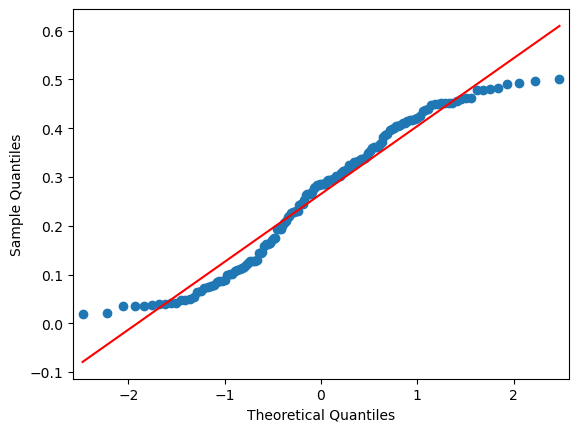

In [12]:
plt.figure(figsize=(10, 6))
sm.qqplot(dark_sample['Click Through Rate'], line='s')
plt.show()

In [13]:
c = sample_data[['Theme','Click Through Rate']].corr()
#mask = np.triu(np.ones_like(c, dtype=bool))

print('Correlation between Theme and CTR:', c['Click Through Rate']['Theme'])

Correlation between Theme and CTR: 0.06983554750315159


In [14]:
sample_data.groupby('Theme', as_index=False)['Click Through Rate'].describe()

,Theme,count,mean,std,min,25%,50%,75%,max
0,0,150.0,0.246043,0.134604,0.013347,0.131714,0.244177,0.343729,0.499080
1,1,150.0,0.265168,0.139463,0.019964,0.133266,0.285082,0.384520,0.499989


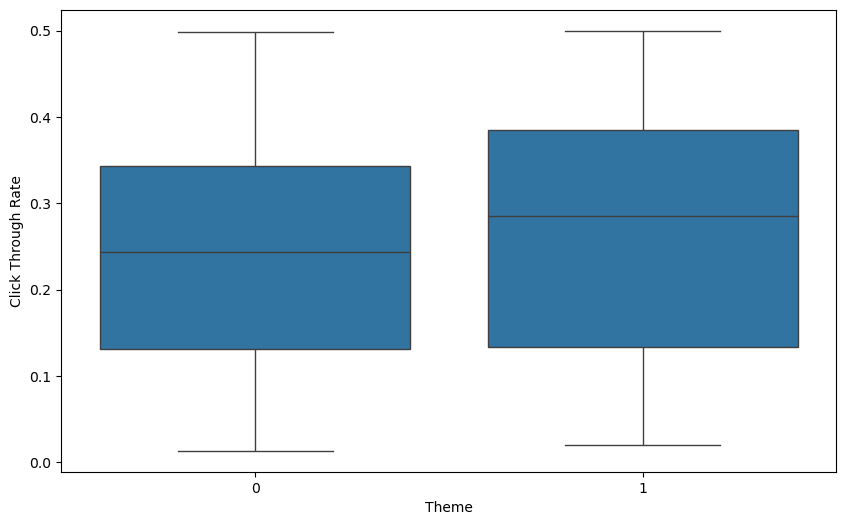

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=sample_data, x='Theme', y='Click Through Rate')
plt.show()

Since the sample data is non-normal and the qq-plots show that the data follows a logistic pattern, this data is non-linear. There is weak positive correlation between Theme and CTR. We can assume that the data is normal because CLT is applicable, as `n=300`. The requirement for constant standard deviation is also satisfied as `2 * smallest std (0.136516) = 0.273032` is greater than the largest standard deviation of `0.140900`. There also appear to be no outliers in the sample for each group.

In [16]:
# 1 way ANOVA
import scipy.stats as stats

f_stat, p_val = stats.f_oneway(light_sample['Click Through Rate'], dark_sample['Click Through Rate'])

print("F-statistic:", f_stat)
print("P-value:", p_val)

F-statistic: 1.4604698178274391
P-value: 0.22781345592215801


In [17]:
anova_data = sample_data[['Theme', 'Click Through Rate']]
anova_data

,Theme,Click Through Rate
4,0,0.034783
438,0,0.472367
535,0,0.152278
915,0,0.283811
759,0,0.387875
...,...,...
712,1,0.302486
369,1,0.120024
205,1,0.479529
739,1,0.264155


In [18]:
anova_data.rename(columns={'Click Through Rate': 'CTR'}, inplace=True)
anova_data.columns

C:\Users\ldmag\AppData\Local\Temp\ipykernel_18508\3351835921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anova_data.rename(columns={'Click Through Rate': 'CTR'}, inplace=True)


Index(['Theme', 'CTR'], dtype='object')

In [41]:
# Levene test
ping.homoscedasticity(data=anova_data, dv='CTR', group='Theme', center='mean').round(2)

,W,pval,equal_var
levene,0.38,0.54,True


In [19]:
# ANOVA table
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = ols('CTR ~ C(Theme)', anova_data).fit()
table = sm.stats.anova_lm(model, typ=2)

print(table)

            sum_sq     df        F    PR(>F)
C(Theme)  0.027434    1.0  1.46047  0.227813
Residual  5.597651  298.0      NaN       NaN


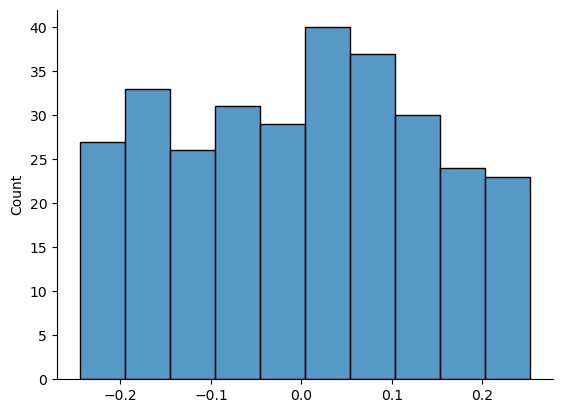

In [42]:
res = model.resid
sns.histplot(res)
sns.despine()

In [43]:
ping.normality(res)

,W,pval,normal
0,0.96167,4.124354e-07,False


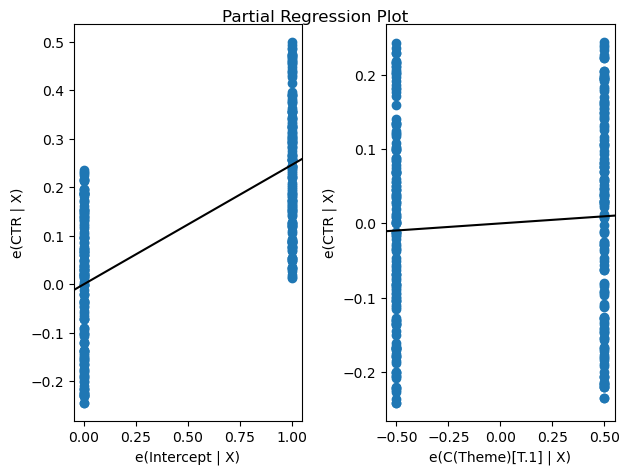

In [30]:
sm.graphics.plot_partregress_grid(model)
plt.show()

In [36]:
import pingouin as ping

ping.anova(dv = 'CTR', between = 'Theme', data=anova_data, detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,Theme,0.027434,1,0.027434,1.46047,0.227813,0.004877
1,Within,5.597651,298,0.018784,NaN,NaN,NaN


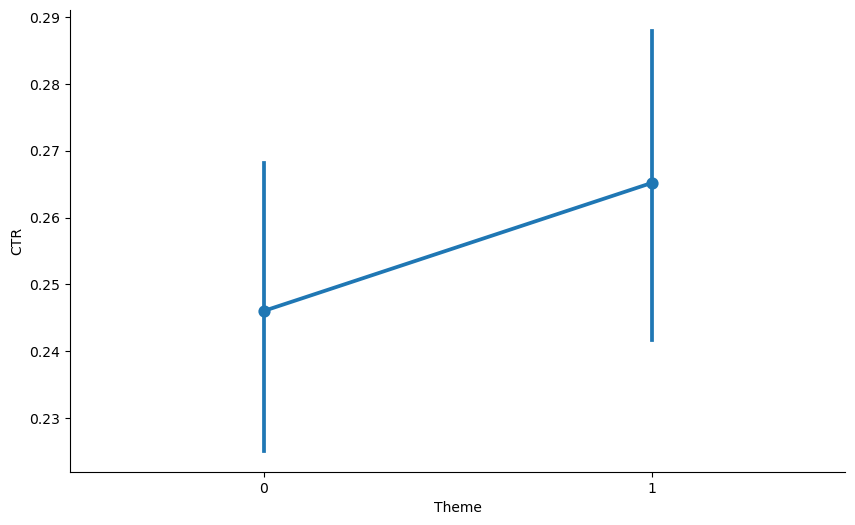

In [37]:
plt.figure(figsize=(10,6))
sns.pointplot(x='Theme', y='CTR', data=anova_data)
sns.despine()
plt.show()

In [40]:
ping.pairwise_tests(dv='CTR', between='Theme', padjust='bonferroni', data=anova_data)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Theme,0,1,False,True,-1.208499,298.0,two-sided,0.227813,0.255,-0.139194


Based on the following p-value of 0.228, and an alpha of 0.05: we fail to reject the null hypothesis. The mean CTR between both groups appear to be the same. 

## Two Way Analysis of Variance

For a two way ANOVA we need multiple categoric variables and a continuous response. We use the location variable and split the data on three categories: 'North India', 'South India', and 'Coastal India', under the new variable 'Region'. We will then attempt to examine the relationship between CTR, Theme, and Region. 

We can state the following hypotheses:

H0: There is no difference in the mean CTR for any Region and Theme.

Ha: There is a difference in mean CTR for one or more regions and themes.


Since we are using the same response as the previous one-way ANOVA, and since our sample sizes for each group are the same - the assumptions for ANOVA are still considered satisfied. 

In [21]:
inverse_theme = {v: k for k, v in map_themes.items()}

In [22]:
raw

,Theme,Click Through Rate,Conversion Rate,Bounce Rate,Scroll_Depth,Age,Location,Session_Duration,Purchases,Added_to_Cart
0,0,0.054920,0.282367,0.405085,72.489458,25,1,1535,0,1
1,0,0.113932,0.032973,0.732759,61.858568,19,4,303,0,1
2,1,0.323352,0.178763,0.296543,45.737376,47,1,563,1,1
3,0,0.485836,0.325225,0.245001,76.305298,58,4,385,1,0
4,0,0.034783,0.196766,0.765100,48.927407,25,3,1437,0,0
...,...,...,...,...,...,...,...,...,...,...
995,1,0.282792,0.401605,0.200720,68.478822,25,2,321,1,1
996,1,0.299917,0.026372,0.762641,73.019821,38,1,1635,1,1
997,0,0.370254,0.019838,0.607136,33.963298,32,0,1237,0,1
998,0,0.095815,0.137953,0.458898,37.429284,24,1,893,1,0


In [23]:
raw['Theme'] = raw['Theme'].map(inverse_theme)
raw['Location'] = LE.inverse_transform(raw['Location'])

In [24]:
raw['Region'] = ''
raw.loc[(raw['Location'] == 'Kolkata') | (raw['Location'] == 'Mumbai'), 'Region'] = 'Coastal'
raw.loc[(raw['Location'] == 'Pune') | (raw['Location'] == 'New Delhi'), 'Region'] = 'North'
raw.loc[(raw['Location'] == 'Bangalore') | (raw['Location'] == 'Chennai'), 'Region'] = 'South'

In [25]:
# randomly sample 300 datapoints
sample_data2 = raw.sample(n=300, random_state=42)
sample_data2.describe()

,Click Through Rate,Conversion Rate,Bounce Rate,Scroll_Depth,Age,Session_Duration,Purchases,Added_to_Cart
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.259842,0.250083,0.500102,49.697928,41.850000,927.460000,0.503333,0.516667
std,0.136006,0.143685,0.174326,16.660757,14.387175,496.985093,0.500824,0.500557
min,0.018933,0.011259,0.200720,20.211974,18.000000,46.000000,0.000000,0.000000
25%,0.149469,0.130255,0.336708,35.428048,29.000000,503.750000,0.000000,0.000000
50%,0.260351,0.263629,0.524255,49.688709,42.000000,927.000000,1.000000,1.000000
75%,0.364141,0.367991,0.647332,63.797461,55.000000,1355.000000,1.000000,1.000000
max,0.499989,0.498874,0.794046,79.842038,65.000000,1795.000000,1.000000,1.000000


In [26]:
two_anovaData = sample_data2[['Click Through Rate', 'Theme', 'Region']]
two_anovaData.rename(columns={'Click Through Rate': 'CTR'}, inplace=True)

C:\Users\ldmag\AppData\Local\Temp\ipykernel_18508\297142345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_anovaData.rename(columns={'Click Through Rate': 'CTR'}, inplace=True)


In [27]:
two_anovaData

,CTR,Theme,Region
521,0.350051,Light Theme,North
737,0.366427,Dark Theme,South
740,0.284835,Dark Theme,North
660,0.062674,Light Theme,South
411,0.276600,Light Theme,North
...,...,...,...
468,0.220998,Light Theme,North
935,0.482253,Dark Theme,North
428,0.182627,Light Theme,North
7,0.395619,Light Theme,South


In [28]:
two_anovaData.groupby('Region', as_index=False)['CTR'].describe()

,Region,count,mean,std,min,25%,50%,75%,max
0,Coastal,62.0,0.256558,0.137862,0.018933,0.144895,0.272815,0.374402,0.499989
1,North,117.0,0.269448,0.139791,0.025869,0.163149,0.274482,0.373037,0.499328
2,South,121.0,0.252235,0.131850,0.028358,0.140693,0.239864,0.359551,0.498610


In [29]:
# Applying the two way anova

model2 = ols('CTR ~ C(Region) + C(Theme) + C(Region):C(Theme)', data=two_anovaData).fit()
table2 = sm.stats.anova_lm(model2, typ=2)

print(table2)

                      sum_sq     df         F    PR(>F)
C(Region)           0.024032    2.0  0.656074  0.519642
C(Theme)            0.085265    1.0  4.655358  0.031767
C(Region):C(Theme)  0.042340    2.0  1.155857  0.316214
Residual            5.384714  294.0       NaN       NaN


In [45]:
ping_twoway = ping.anova(dv = 'CTR', between=['Theme', 'Region'], data=two_anovaData, detailed=True)
round(ping_twoway, 4)

,Source,SS,DF,MS,F,p-unc,np2
0,Theme,0.0853,1.0,0.0853,4.6554,0.0318,0.0156
1,Region,0.0240,2.0,0.0120,0.6561,0.5196,0.0044
2,Theme * Region,0.0423,2.0,0.0212,1.1559,0.3162,0.0078
3,Residual,5.3847,294.0,0.0183,NaN,NaN,NaN


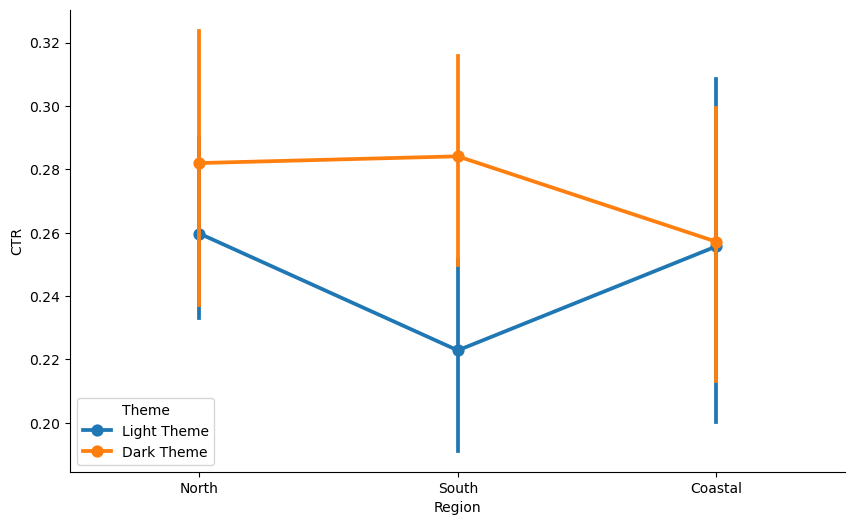

In [49]:
plt.figure(figsize=(10,6))
sns.pointplot(data=two_anovaData, x='Region', y='CTR', hue='Theme')
sns.despine()
plt.show()

<Figure size 1200x600 with 0 Axes>

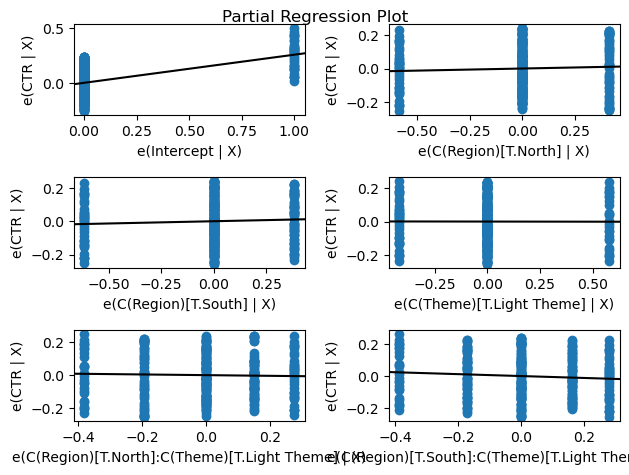

In [34]:
plt.figure(figsize=(12,6))
sm.graphics.plot_partregress_grid(model2)
plt.show()

Based on the p-values obtained; we can determine that the 'Theme' variable has the most significant influence over CTR (p=0.0318). Region and a combination of Region + Theme are determined to be not significant (p=0.520 and p=0.316); assuming an alpha of 0.05. 

In examining the effects plot - there does not seem to be any significant influence from the factors on the response variable. 

## Generalized Linear Model (Test)

We follow a similar logic and hypothesis to the two way ANOVA.

In [35]:
import statsmodels.formula.api as smf
model3 = smf.glm("CTR ~ C(Region) + C(Theme)", data=two_anovaData, family=sm.families.Binomial())
result = model3.fit()

print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    CTR   No. Observations:                  300
Model:                            GLM   Df Residuals:                      296
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -120.85
Date:                Fri, 25 Oct 2024   Deviance:                       30.625
Time:                        11:43:25   Pearson chi2:                     28.2
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001796
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 